In [1]:
import sys
sys.path.append("..")

In [9]:
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
import numpy as np
import torch
import torch.utils.data as data

from laplace import Laplace, marglik_training

import matplotlib.pyplot as plt
%matplotlib inline

n_epochs = 1000
torch.manual_seed(711)

In [10]:
x1 = torch.rand(50, 1) * 0.3 - 1
x2 = torch.rand(50, 1) * 0.5 + 0.5
x = torch.cat([x1, x2])
y = x.mul(4).add(0.8).cos() + 0.1 * torch.randn_like(x)

x_test = torch.linspace(-2, 2, 401).unsqueeze(-1)
y_test = x_test.mul(4).add(0.8).cos()

In [11]:
dataset = data.TensorDataset(x, y)
train_loader = data.DataLoader(dataset, batch_size=len(x))

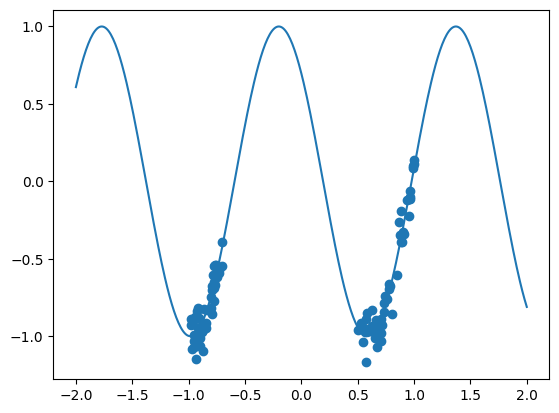

In [12]:
plt.scatter(x.squeeze(), y)
plt.plot(x_test.squeeze(), y_test)

In [13]:
# create and train MAP model
def get_model():
    torch.manual_seed(711)
    return torch.nn.Sequential(
        torch.nn.Linear(1, 50), torch.nn.Tanh(), torch.nn.Linear(50, 1)
    )
model = get_model()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for i in range(n_epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()

In [14]:
la = Laplace(model, 'regression', subset_of_weights='all', hessian_structure='full')
la.fit(train_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [15]:
x = x_test.flatten().cpu().numpy()
f_mu, f_var = la(x_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

(-2.0, 2.0)

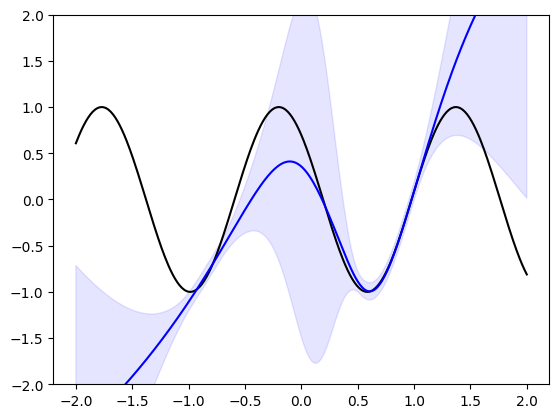

In [18]:
#plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
plt.plot(x_test, f_mu, color="blue")
plt.fill_between(x_test.squeeze(), (f_mu - pred_std).squeeze(), (f_mu + pred_std).squeeze(), alpha=0.1, color="blue")
plt.ylim(-2, 2)